In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [56]:
BATCH_SIZE = 32
EPOCHS = 100
NUM_USERS = 10
NUM_IMAGES_PER_USER = 100
latent_dim = 100
IMG_HEIGHT, IMG_WIDTH = 256, 256

In [57]:
def define_discriminator(in_shape=(256, 256, 3), n_classes=NUM_USERS):
    
    # label input
    in_label = Input(shape=(1,))  #Shape 1
    # embedding for categorical input
    # each label will be represented by a vector of size 50. 
    # This vector of size 50 will be learnt by the discriminator
    li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]  #256x256 
    
    li = Dense(n_nodes)(li)  #Shape = 1, 256x256
    # reshape to additional channel
    
    li = Reshape((in_shape[0], in_shape[1], 1))(li)  #256x256x1
    
    
    # image input
    in_image = Input(shape=in_shape) #32x32x3
    # concat label as a channel
    merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
    # downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)  #8192  (8*8*128=8192)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
    # define model
    ##Combine input label with input image and supply as inputs to the model. 
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim, n_classes=NUM_USERS):
    
    # label input
    in_label = Input(shape=(1,))  #Input of dimension 1
    # embedding for categorical input
    #each label will be represented by a vector of size 50. 
    li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
    # linear multiplication
    n_nodes = 64 * 64  # To match the dimensions for concatenation later in this step.  
    li = Dense(n_nodes)(li) #1,64
    # reshape to additional channel
    li = Reshape((64, 64, 1))(li)
    
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
    # foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer. 
    #While defining model inputs we will combine input label and the latent input.
    n_nodes = 128 * 64 * 64
    gen = Dense(n_nodes)(in_lat)  #shape=8192
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((64, 64, 128))(gen) #Shape=8x8x128
    # merge image gen and label input
    merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model   #Model not compiled as it is not directly trained like the discriminator.


def define_gan(g_model, d_model):
    d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    ## connect generator and discriminator...
    # first, get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input  #Latent vector size and label size
    # get image output from the generator model
    gen_output = g_model.output  #256x256x3
    
    # generator image output and corresponding input label are inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=EPOCHS, n_batch=BATCH_SIZE):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)    
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # Print losses on this batch
            print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    g_model.save('conditional_generator.h5')

In [58]:
# # select real samples
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset  
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
    y = ones((n_samples, 1))  #Label=1 indicating they are real
    return [X, labels], y

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return [images, labels_input], y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=NUM_USERS):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [230]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 1, 50)        2500        ['input_51[0][0]']               
                                                                                                  
 dense_49 (Dense)               (None, 1, 65536)     3342336     ['embedding_25[0][0]']           
                                                                                                  
 input_52 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                         

In [231]:
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_53 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_52 (Dense)               (None, 524288)       52953088    ['input_54[0][0]']               
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 50)        2500        ['input_53[0][0]']               
                                                                                           

In [232]:
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_53 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_52 (Dense)               (None, 524288)       52953088    ['input_54[0][0]']               
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 50)        2500        ['input_53[0][0]']               
                                                                                           

In [238]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

def load_real_samples():
    # Define the path to your dataset
    dataset_path = os.path.join(os.getcwd(), 'datasets', 'labelled_jabcode_augmented')

    # Specify image dimensions
    img_width, img_height = IMG_WIDTH, IMG_HEIGHT

    # Set the batch size
    batch_size = BATCH_SIZE

    # Use ImageDataGenerator for data augmentation and normalization
    datagen = ImageDataGenerator(
        rescale=1./255,  # normalize pixel values to [0,1]
#         validation_split=0.2  # set the validation split
    )

    # Generate the training dataset
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(img_width, img_height),
        batch_size=-1,
        class_mode='sparse',
        subset='training',  # set as training data
        classes=os.listdir(dataset_path)
    )

#     # Generate the validation dataset
#     validation_generator = datagen.flow_from_directory(
#         dataset_path,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode='sparse',
#         subset='validation',  # set as validation data
#         classes=os.listdir(dataset_path)
#     )

#     # Get the number of classes
#     num_classes = len(train_generator.class_indices)

    class_to_label = {v: k for k, v in train_generator.class_indices.items()}
    
    # Alternatively, you can use the generators to get the data and labels
    X_train, y_train = train_generator.next()
#     X_val, y_val = validation_generator.next()

    X_train = X_train.astype('float32')
    X_train = (X_train - 127.5) / 127.5 #Coz the output layer is tanh, so we noramlize images between -1, 1
#     y_train = np.array([np.float32(class_to_label.get(value, value)) for value in y_train])

#     X_val = X_val.astype('float32')
#     y_val = [class_to_label.get(value, value) for value in y_val]
#     # Convert labels to one-hot encoding
#     y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
#     y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

    
    return [X_train, y_train]#, [X_val, y_val]

In [239]:
dataset = load_real_samples()

imgs, lbls = dataset
imgs.shape, len(lbls)

Found 22084 images belonging to 220 classes.


MemoryError: Unable to allocate 16.2 GiB for an array with shape (22083, 256, 256, 3) and data type float32

In [223]:
dataset = load_real_samples()

imgs, lbls = dataset
imgs.shape, len(lbls)
# ix = [14, 10,  1, 16, 15, 14, 11, 17,  8, 19]
# imgs[1, 2, 3]
lbls
# type(imgs), type(lbls) 

Found 202 images belonging to 2 classes.


array([1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1.], dtype=float32)

In [224]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2)

Found 202 images belonging to 2 classes.
1/1 [==============================] - 5s 5s/step
Epoch>1, Batch1/1, d1=0.624, d2=0.696 g=0.708
1/1 [==============================] - 4s 4s/step
Epoch>2, Batch1/1, d1=0.000, d2=0.691 g=0.722


In [87]:
##########################################################
# Now, let us load the generator model and generate images
# Lod the trained model and generate a few images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
# 


# load model
model = load_model('conditional_generator.h5')

In [95]:
latent_points, _ = generate_latent_points(100, 1)
latent_points.shape

# # specify labels - generate 10 sets of labels each gping from 0 to 9
# labels = asarray([x for _ in range(10) for x in range(2)])
# labels

# X = (X + 1) / 2.0
# X = (X*255).astype(np.uint8)

1/1 [==============================] - 1s 960ms/step


1/1 [==============================] - 1s 853ms/step


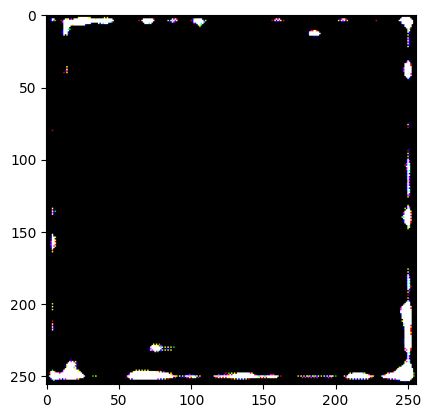

In [99]:
X  = model.predict([latent_points, np.array([0])])
X.shape
plt.imshow(np.uint8(X[0]))

1/1 [==============================] - 1s 776ms/step


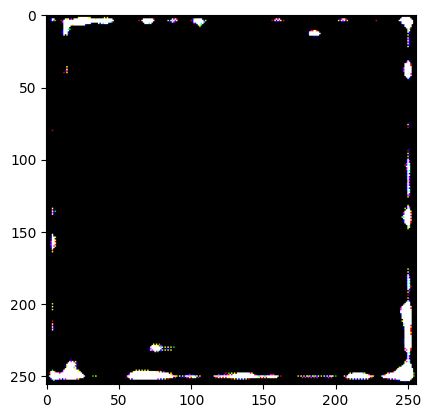

In [100]:
X  = model.predict([latent_points, np.array([0])])
X.shape
plt.imshow(np.uint8(X[0]))

1/1 [==============================] - 1s 835ms/step


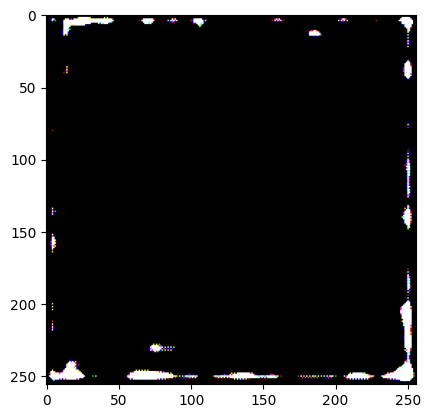

In [101]:
X  = model.predict([latent_points, np.array([2])])
X.shape
plt.imshow(np.uint8(X[0]))

1/1 [==============================] - 1s 756ms/step


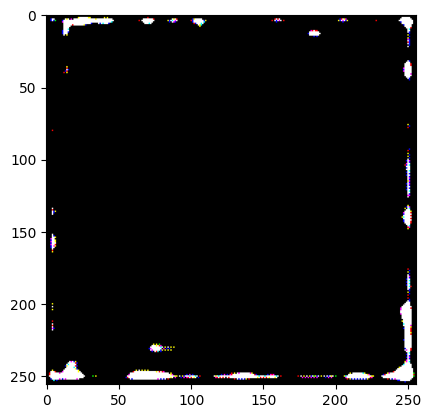

In [102]:
X  = model.predict([latent_points, np.array([3])])
X.shape
plt.imshow(np.uint8(X[0]))

In [62]:
# generate multiple images

latent_points, labels = generate_latent_points(100, 10)
latent_points.shape, labels.shape

# # specify labels - generate 10 sets of labels each gping from 0 to 9
# labels = asarray([x for _ in range(10) for x in range(2)])
# labels

# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]

# X = (X + 1) / 2.0
# X = (X*255).astype(np.uint8)

# # plot the result (10 sets of images, all images in a column should be of same class in the plot)
# # Plot generated images 
# def show_plot(examples, n):
#     for i in range(n * n):
#         plt.subplot(n, n, 1 + i)
#         plt.axis('off')
#         plt.imshow(examples[i, :, :, :])
#     plt.show()
    
# show_plot(X, 10)


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/embedding_1/embedding_lookup' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\miniconda3\envs\tensorflow_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HK Joshi\AppData\Local\Temp\ipykernel_20656\1732590925.py", line 12, in <module>
      X  = model.predict([latent_points, labels])
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HK Joshi\AppData\Roaming\Python\Python311\site-packages\keras\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_1/embedding_1/embedding_lookup'
indices[3,0] = 9 is not in [0, 5)
	 [[{{node model_1/embedding_1/embedding_lookup}}]] [Op:__inference_predict_function_451]

In [43]:
# # MEMORY EFFICIENT CODE

# augmented_data_folder = r'datasets\jabcode_exchange_replace_augmented'

# # # Initialize empty lists to store user data and user IDs
# # user_data = []
# # user_ids = []

# user_ids_mapping = {}
# for i in range(1, NUM_USERS+1):
#     user_ids_mapping[i] = np.array([i] * BATCH_SIZE, dtype=np.int32)

# # Loop through the folders for each user
# for user_id in range(1, NUM_USERS + 1):
#     user_data_folder = os.path.join(augmented_data_folder, f'user_{user_id}')
    
#     user_images = []  # To store images for the current user
# #     user_id_array = np.array([user_id] * NUM_IMAGES_PER_USER, dtype=np.int32)  # User IDs for the current user
    
#     for image_id in range(1, NUM_IMAGES_PER_USER+1):
#         image_filename = f'jabcode_user_{user_id}_augmented_{image_id}.png'
#         image_path = os.path.join(user_data_folder, image_filename)
        
#         # Load and preprocess the image
#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
#         image = cv2.resize(image, (256, 256))  # Resize if needed
#         image = np.reshape(image, (256, 256, 1))
#         # print(image.shape)
# #         user_images.append(image)
    
#         # Main training loop
#         for epoch in range(EPOCHS):
#             print('***********************************************************************************************************')
#             print(f'user_id {user_id}\n')
#             print(f'    Epoch {epoch+1}')

#             train_step(image, user_ids_mapping[user_id])
#         print('***********************************************************************************************************')
        
    
    
# ValueError                                Traceback (most recent call last)
# Cell In[40], line 37
#      34     print(f'user_id {user_id}\n')
#      35     print(f'    Epoch {epoch+1}')
# ---> 37     train_step(image, user_ids_mapping[user_id])
#      38 print('***********************************************************************************************************')

# File ~\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\traceback_utils.py:153, in filter_traceback.<locals>.error_handler(*args, **kwargs)
#     151 except Exception as e:
#     152   filtered_tb = _process_traceback_frames(e.__traceback__)
# --> 153   raise e.with_traceback(filtered_tb) from None
#     154 finally:
#     155   del filtered_tb

# File ~\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py:935, in Function._call(self, *args, **kwds)
#     933   results = self._variable_creation_fn(*args, **kwds)
#     934   if self._created_variables and not ALLOW_DYNAMIC_VARIABLE_CREATION:
# --> 935     raise ValueError("Creating variables on a non-first call to a function"
#     936                      " decorated with tf.function.")
#     937   return results
#     939 try:
#     940   # This is the first call of __call__, so we have to initialize.

# ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [77]:
augmented_data_folder = r'datasets\jabcode_exchange_replace_augmented'

# Initialize empty lists to store user data and user IDs
user_data = []
user_ids = []

# Loop through the folders for each user
for user_id in range(NUM_USERS):
    user_data_folder = os.path.join(augmented_data_folder, f'user_{user_id+1}')
    
    user_images = []  # To store images for the current user
    user_id_array = np.array([user_id] * NUM_IMAGES_PER_USER, dtype=np.int32)  # User IDs for the current user
    
    for image_id in range(NUM_IMAGES_PER_USER):
        image_filename = f'jabcode_user_{user_id+1}_augmented_{image_id+1}.png'
        image_path = os.path.join(user_data_folder, image_filename)
        
        # Load and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        image = cv2.resize(image, (256, 256))  # Resize if needed
        image = np.reshape(image, (256, 256, 1))
        # print(image.shape)
        user_images.append(image)
    
    user_data.append(user_images)
    user_ids.append(user_id_array)

In [78]:
user_ids

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

***********************************************************************************************************
***********************************************************************************************************
Epoch 1
    user_id 0



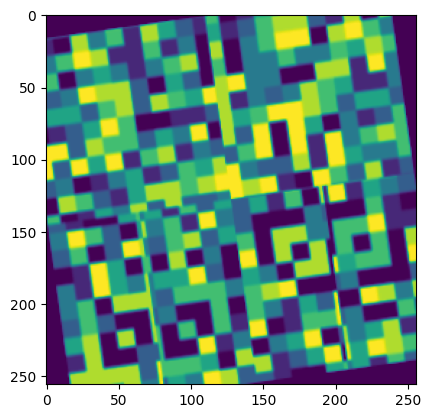

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


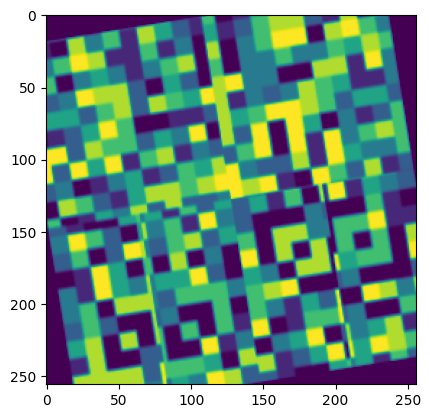

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


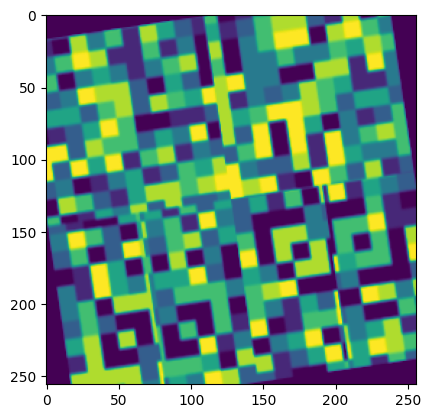

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


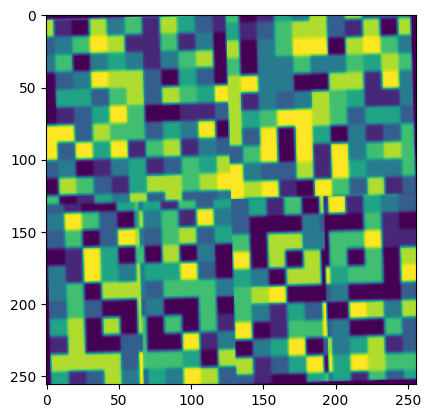

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


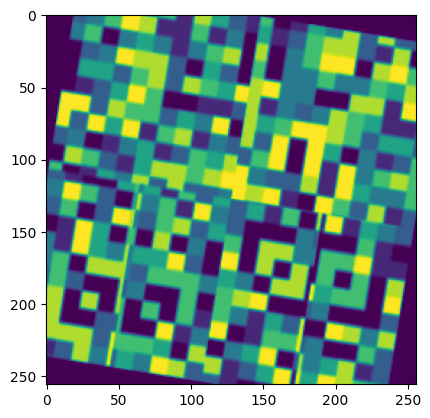

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


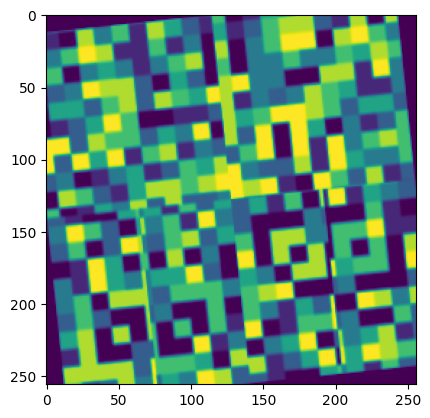

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


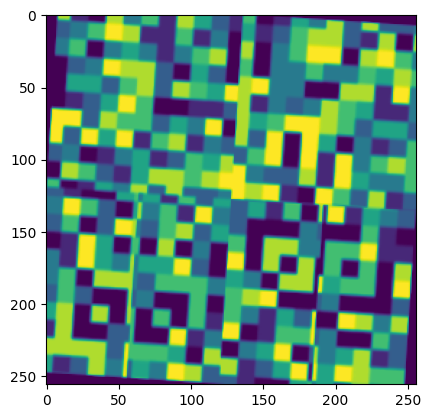

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


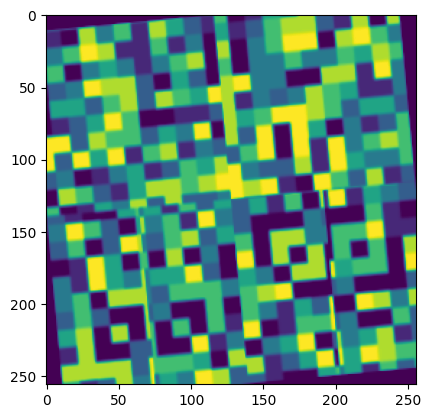

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


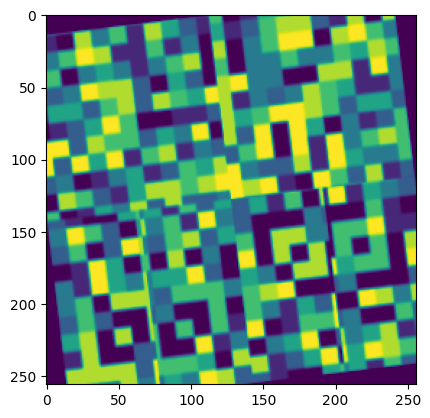

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


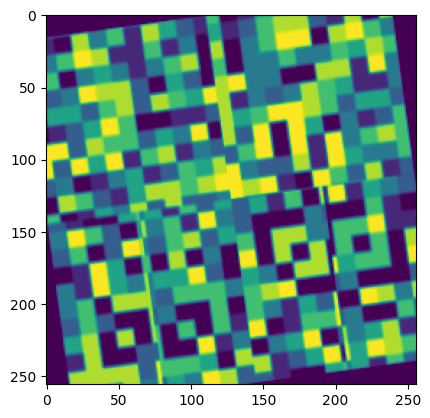

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


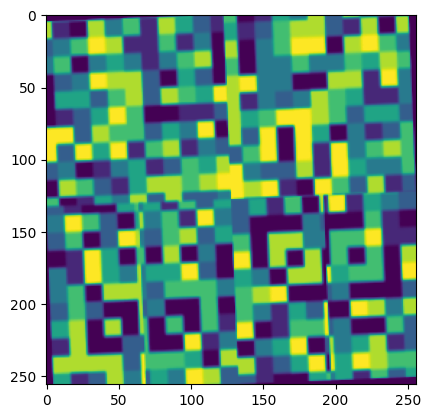

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


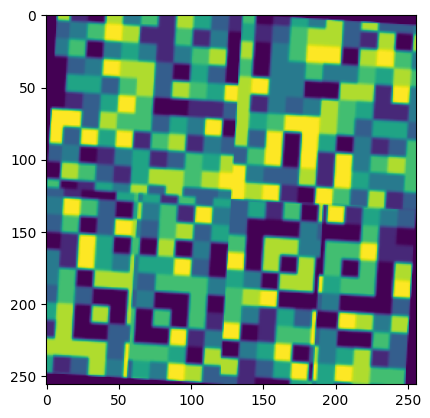

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


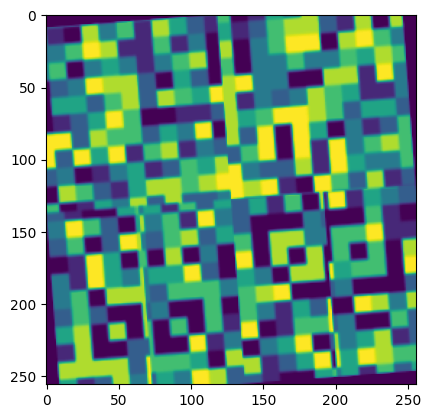

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


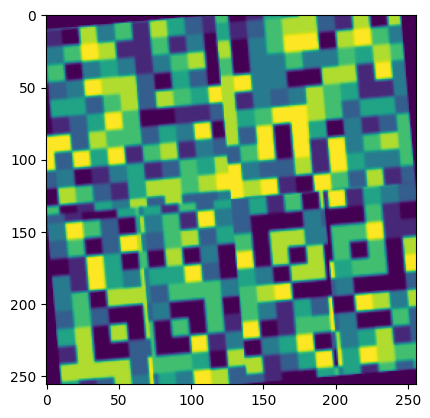

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Now you have user_data, a list of lists containing user-specific images, and user_ids, a list of user IDs corresponding to each user's images.

# You can use these arrays to train your cGAN.

# Assuming you have already loaded and organized your data as user_data and user_ids

# Create a user ID to condition mapping
user_ids_mapping = {}
for i in range(NUM_USERS):
    user_ids_mapping[i] = np.array([i] * BATCH_SIZE, dtype=np.int32)
    
# Main training loop
for epoch in range(EPOCHS):
    print('***********************************************************************************************************')
    print('***********************************************************************************************************')
    print(f'Epoch {epoch+1}')
    
    for user_id in range(NUM_USERS):
        print(f'    user_id {user_id}\n')
        for batch_images in user_data[user_id]:
#             plt.imshow(batch_images)
#             plt.show()
#             print(user_ids_mapping[user_id])
            train_step(batch_images, user_ids_mapping[user_id])
#         break
#     break